In [7]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scanpy as sc
import scipy
import anndata
import torch
from torch import tensor as tt

# **Spatial fit**

In this notebook we try to fit some functions that describe the change  
in space of gene expression in the mice brain. Since it is bulk sequencing  
there are several cell typer which add variarion and might pollute our data

In [8]:
# immport the anndata file
adata = sc.read_h5ad('data/adata_hexagon.h5ad')
adata

AnnData object with n_obs × n_vars = 82 × 27462
    obs: 'x', 'y', 'z', 'counts'
    layers: 'log', 'norm'

In [9]:
zonated_genes = np.array(
    ["Vip", "Avp", "Prok2", "Penk", "Vipr2", "Avpr1a", "Prokr2", "Cck", "Grp", "Syt1"]
)

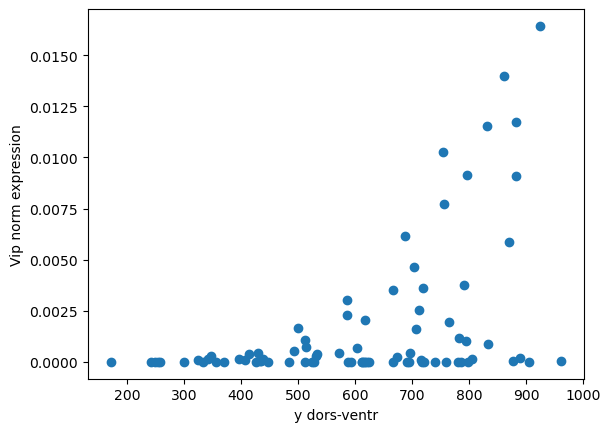

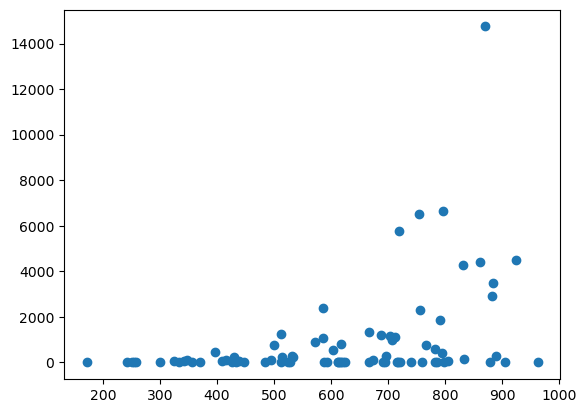

In [10]:
# plot Vip agaonst y coord
plt.scatter(adata.obs['y'], adata[:,'Vip'].layers['norm'])
plt.xlabel('y dors-ventr')
plt.ylabel('Vip norm expression')
#plt.yscale('log')
plt.show()
# now non noralied data
plt.scatter(adata.obs['y'], adata[:,'Vip'].X)

In [11]:
# create a matrix with x , y and z obs from adata, joining the 3 vectors as three columns
# and then convert it to a tensor

coord = np.stack((adata.obs['x'], adata.obs['y'], adata.obs['z']), axis=-1)
# normalize the data    
coord = (coord - coord.mean(axis=0))/coord.std(axis=0)

xx = np.linspace(coord[:,0].min() , coord[:,0].max(), 1000)
yy = np.linspace(coord[:,1].min() , coord[:,1].max(), 1000)
zz = np.linspace(coord[:,2].min() , coord[:,2].max(), 1000)

# vector of variables used to plot
space = np.stack((xx, yy, zz), -1)
space

array([[-1.52578004, -2.30725508, -1.97932127],
       [-1.52205828, -2.30308561, -1.97523406],
       [-1.51833653, -2.29891614, -1.97114684],
       ...,
       [ 2.18480687,  1.84971023,  2.09563245],
       [ 2.18852862,  1.8538797 ,  2.09971967],
       [ 2.19225037,  1.85804918,  2.10380688]])

# torch model

In [12]:
# normalizing all 3 spatial positions

# coord  = tt(adata.obs['y'])
# coord = (coord - coord.mean())/coord.std()
# coord



In [13]:
#rescal lenghts bu a factor 100???

# defining non leaf vectors
x = coord.clone()
y = tt(adata[:,'Vip'].X)
n_count = tt(adata.obs['counts'])

# defining leaf vectors
theta = tt([-6.75 , 1., -1000.])
theta.requires_grad = True
disp = tt(0.3, requires_grad=True)
theta

AttributeError: 'numpy.ndarray' object has no attribute 'clone'

In [ ]:
# def parabola(x, theta):
#     return np.exp(theta[0] + theta[1] * x + theta[2] * x ** 2)

def parabola(x, theta):
    return np.exp(theta[0] + theta[1] * x + np.exp(theta[2]) * x ** 2)

In [ ]:
def GLM_loss(x, y, n_count, theta, disp):
 
    NC = y.shape[0]

    a = - torch.exp(theta[2])
    lmbda = theta[0] + theta[1] * x + a * x ** 2
    lmbda = torch.exp(lmbda) * n_count

    alpha = torch.exp(disp)

    r = 1 / alpha
    p = alpha * lmbda / (1 + alpha * lmbda)
    NB = torch.distributions.NegativeBinomial(
        total_count=r, probs=p, validate_args=None
    )
    
    return -NB.log_prob(y).sum()
GLM_loss(x, y, n_count, theta, disp)

tensor(87607.7165, dtype=torch.float64, grad_fn=<NegBackward0>)

In [ ]:
optimizer = torch.optim.Adam([theta, disp], lr=0.001)
losses = []

In [ ]:
for step in range(10000):
       optimizer.zero_grad()  # zero the gradients
       output = GLM_loss(x, y, n_count, theta, disp)
       output.backward()  # compute the gradients
       optimizer.step()  # update the variable
       losses.append(output.detach())

Text(0.5, 1.0, '41253.43549800235')

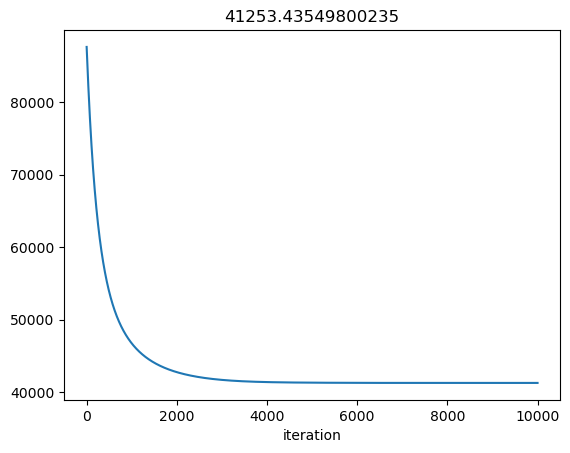

In [ ]:
# print loss
plt.plot(losses)
plt.xlabel('iteration')
plt.title(GLM_loss(x, y, n_count, theta, disp).detach().numpy())

In [ ]:
Theta = theta.detach().numpy()
xx = np.linspace(coord.min() , coord.max(), 1000)

print(Theta)
print(np.exp(disp.detach().numpy()))

[-5.9774551e+00 -4.1372913e-01 -1.0000000e+03]
6.803197


Text(0, 0.5, 'Vip norm expression')

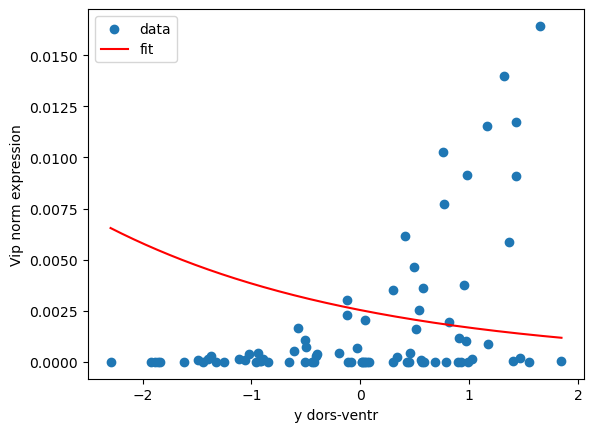

In [ ]:
plt.scatter(coord , adata[:,'Vip'].layers['norm'], label = 'data')
plt.plot(xx, parabola(xx, Theta), c = 'r', label = 'fit')
plt.legend()
plt.xlabel('y dors-ventr')
plt.ylabel('Vip norm expression')

In [ ]:
adata[:, 'Vip'].layers['norm'].squeeze()

ArrayView([3.43996065e-06, 0.00000000e+00, 0.00000000e+00, 1.96320070e-03,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 0.00000000e+00,
           3.58315059e-06, 1.64431224e-06, 0.00000000e+00, 0.00000000e+00,
           0.00000000e+00, 0.00000000e+00, 0.00000000e+00, 2.23009794e-05,
           8.87858972e-06, 0.00000000e+00, 0.00000000e+00, 3.11549211e-05,
           0.00000000e+00, 0.00000000e+00, 2.54865512e-03, 4.36629742e-06,
           0.00000000e+00, 0.00000000e+00, 3.77504070e-03, 6.68169252e-04,
           4.55332125e-04, 8.95423491e-06, 9.09726718e-03, 1.60511299e-03,
           2.90423217e-04, 0.00000000e+00, 1.58105948e-04, 0.00000000e+00,
           7.72271735e-03, 3.01943335e-03, 4.09189487e-04, 1.90484107e-05,
           1.39802527e-02, 6.15081806e-03, 7.08669298e-04, 1.37796034e-04,
           9.12439241e-03, 2.07235433e-03, 1.24999760e-04, 7.58624614e-05,
           1.15438870e-02, 3.49827040e-03, 1.67432101e-03, 1.10096976e-04,
           1.64301334e-02

# scipy model

In [14]:
# fit an exponential function to the data with scipy
# the x is coord and y is adata[:,'Vip'].layers['norm']

from scipy.optimize import curve_fit

def func(x, a, b):
    return  np.exp(a * x + b) 

Text(0, 0.5, 'Vip norm expression')

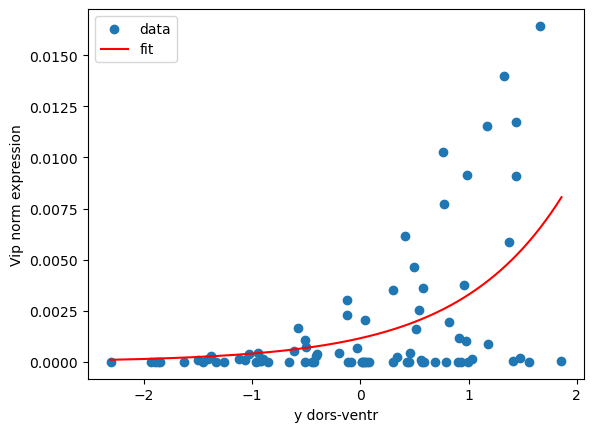

In [15]:
coef, _ = curve_fit(func, coord[:,1], adata[:,'Vip'].layers['norm'].squeeze(), p0=(0, 0))

plt.scatter(coord[:,1] , adata[:,'Vip'].layers['norm'], label = 'data')
plt.plot(yy, func(yy, *coef), c = 'r', label = 'fit')
plt.legend()
plt.xlabel('y dors-ventr')
plt.ylabel('Vip norm expression')

## parabola fits

In [16]:
def func_2(x, a, b, c):
    return  np.exp(a * x**2 + b * x + c)

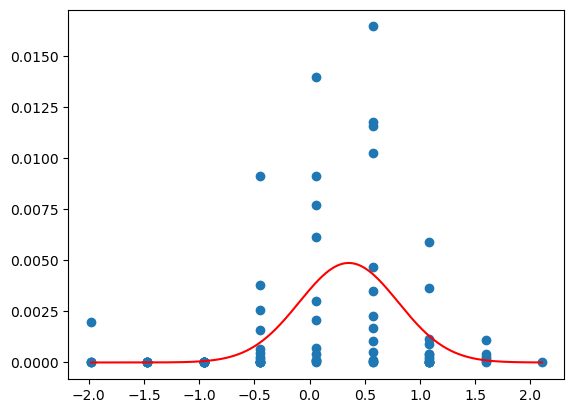

In [17]:
coef2, _ = curve_fit(func_2, coord[:,2], adata[:,'Vip'].layers['norm'].squeeze(), p0=(0, 0, 0))

zz = np.linspace(coord[:,2].min() , coord[:,2].max(), 1000)

plt.scatter(coord[:,2] , adata[:,'Vip'].layers['norm'], label = 'data')
plt.plot(zz, func_2(zz, *coef2), c = 'r', label = 'fit')


array([[ 0.8325862 , -1.9671354 ,  1.06595341],
       [-1.9671354 ,  4.79372169, -2.70163587],
       [ 1.06595341, -2.70163587,  1.61047136]])

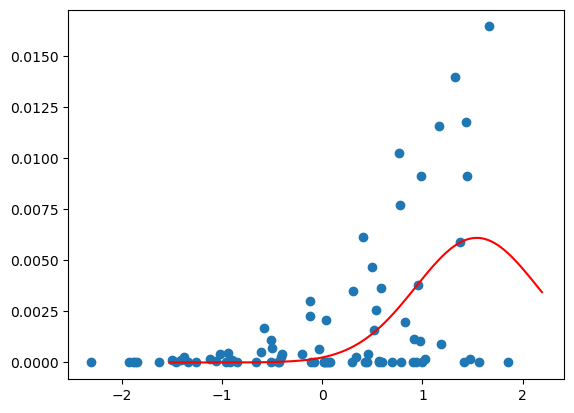

In [18]:
# same fit and plot but fitting vip

coef, _ = curve_fit(func_2, coord[:,1], adata[:,'Vip'].layers['norm'].squeeze(), p0=(0, 0, 0))

plt.scatter(coord[:,1] , adata[:,'Vip'].layers['norm'], label = 'data')
plt.plot(xx, func_2(xx, *coef), c = 'r', label = 'fit')

_


In [29]:
space_labels = np.array(['med-lat', 'dors-vent', 'ant-post'  ])

# create a vector to store the fitted parameters
theta = np.zeros((len(zonated_genes), 3))


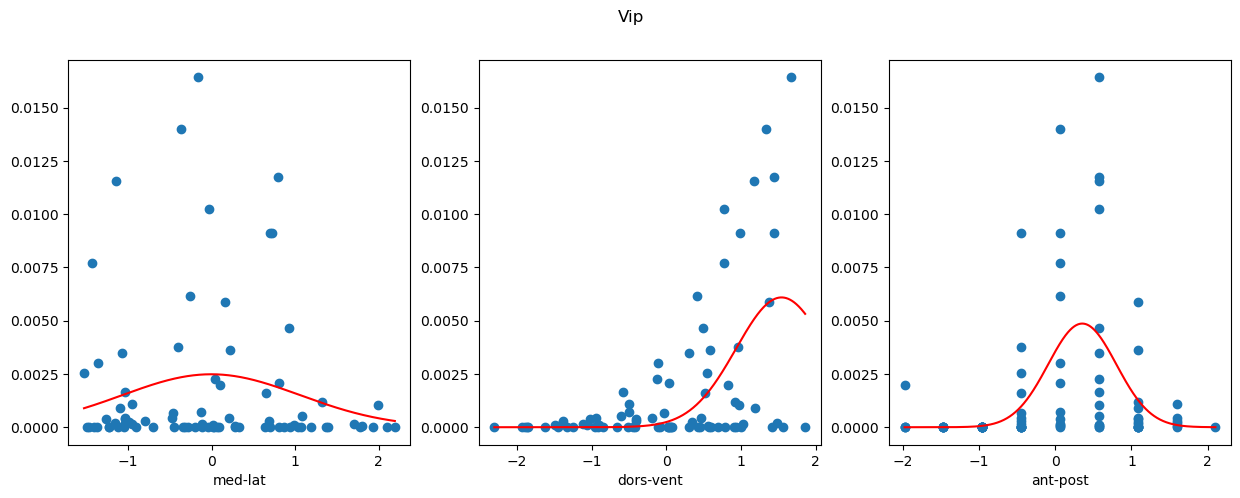

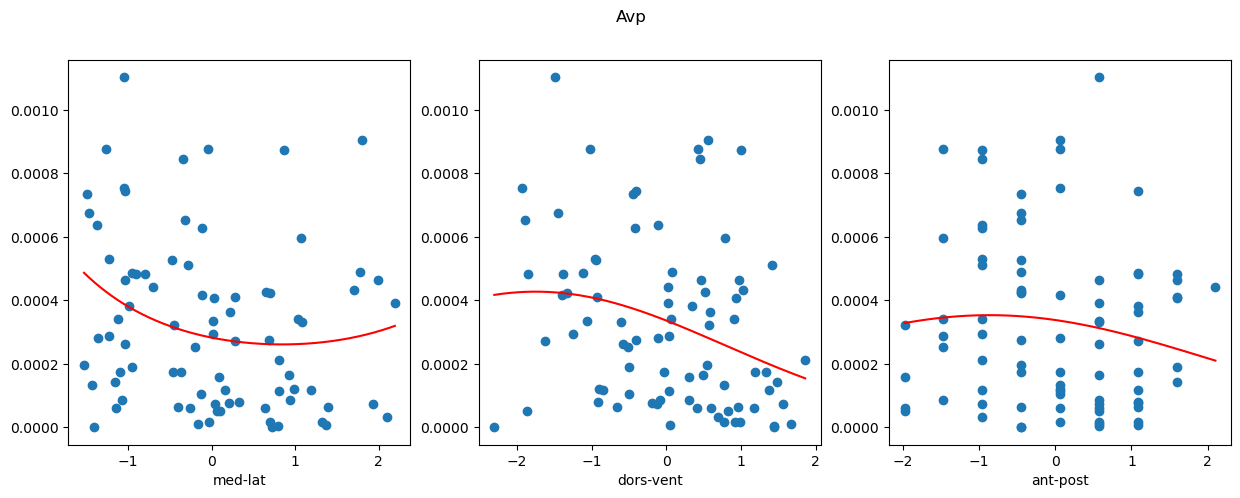

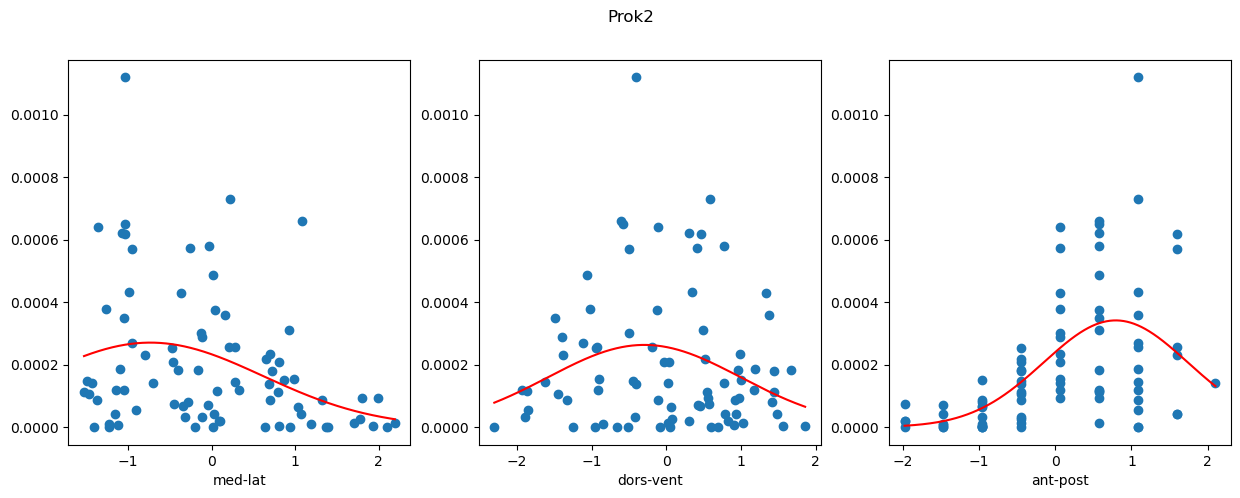

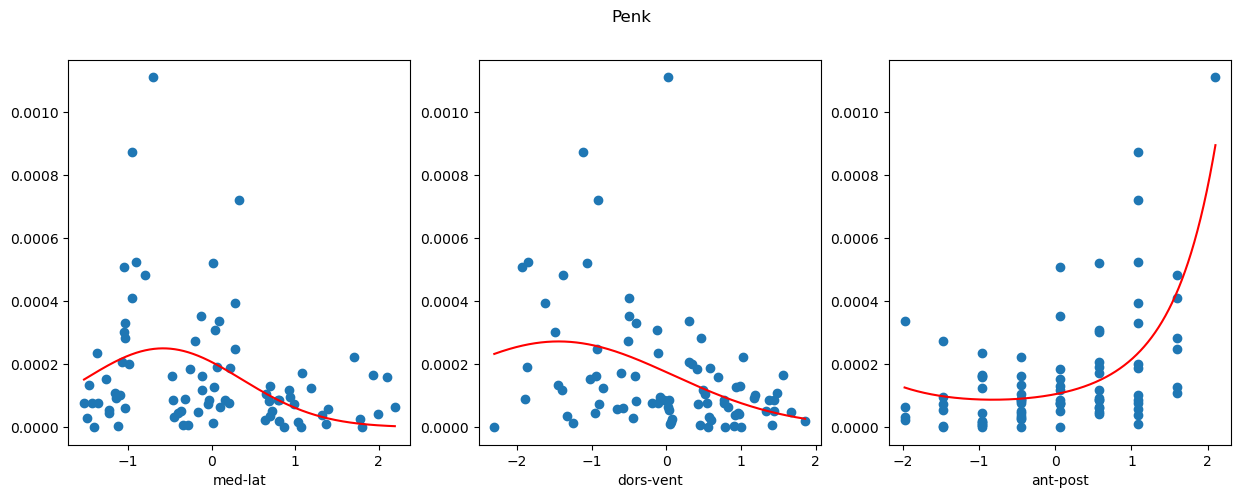

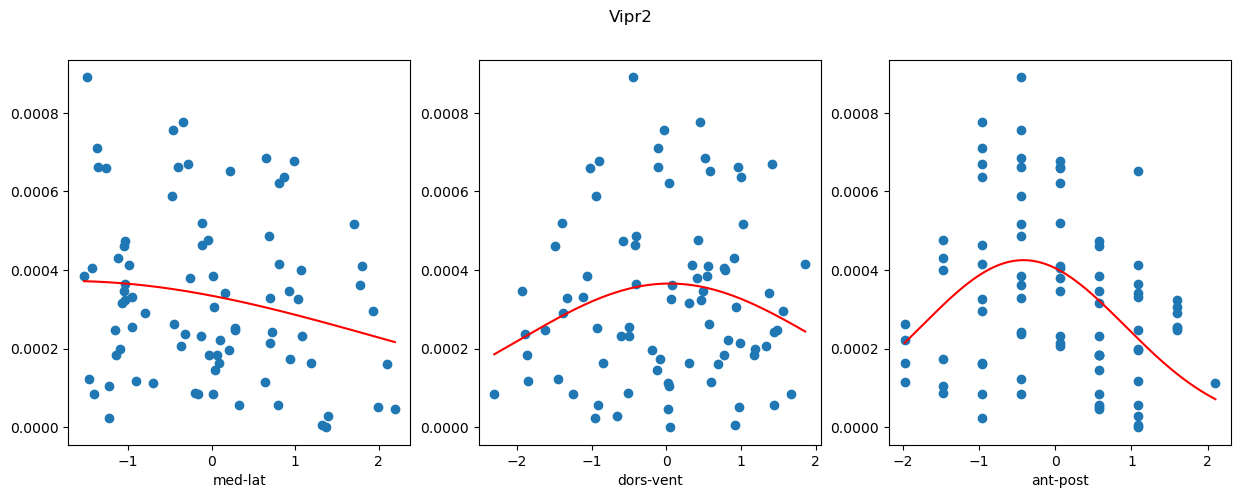

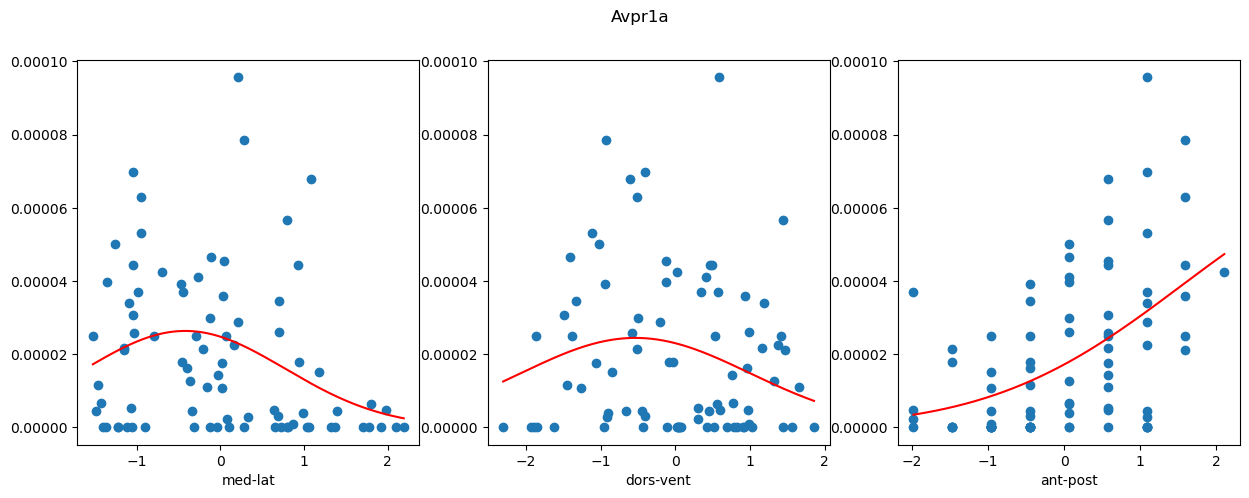

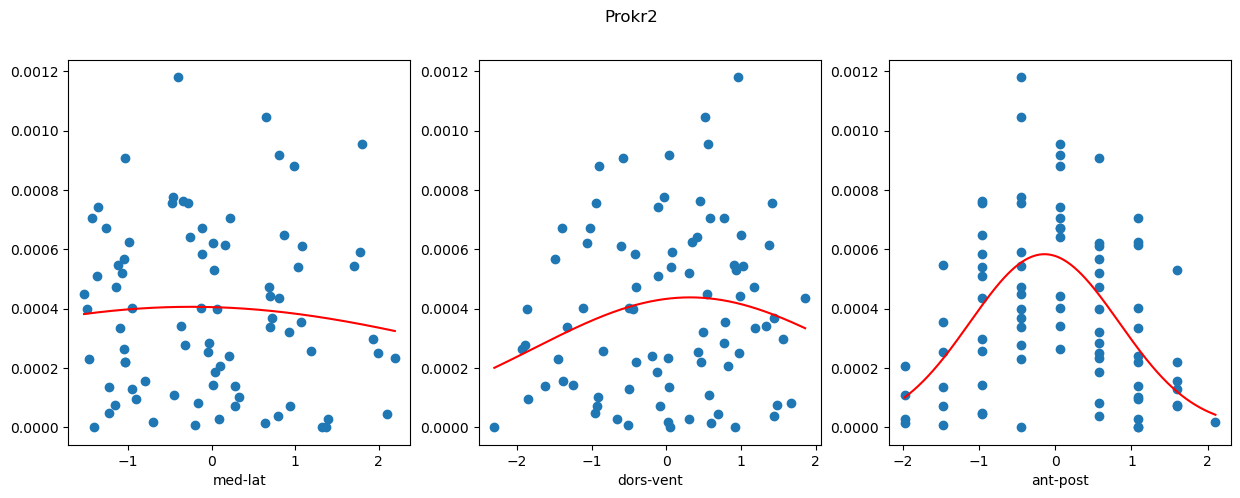

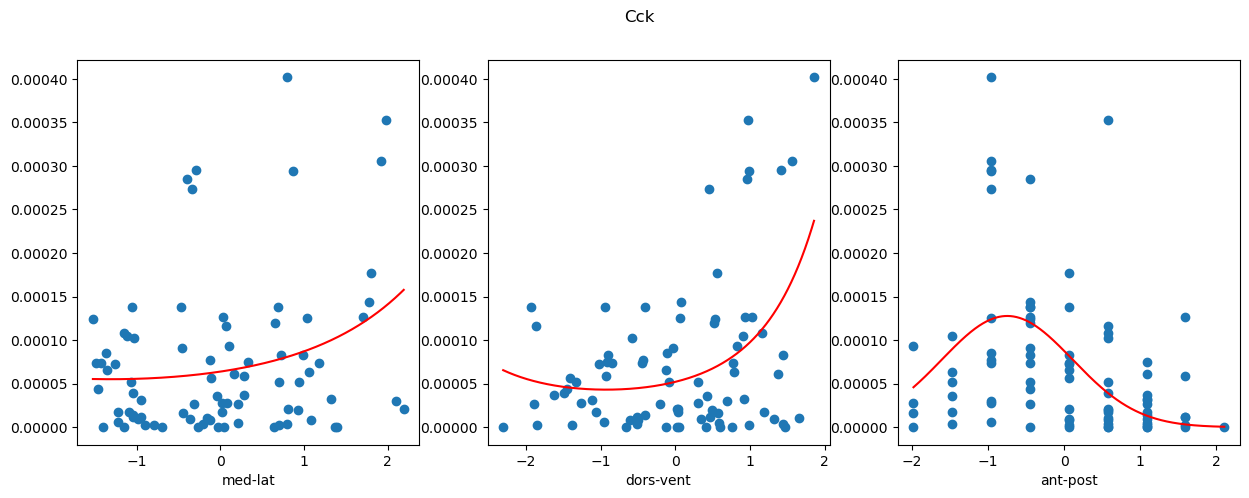

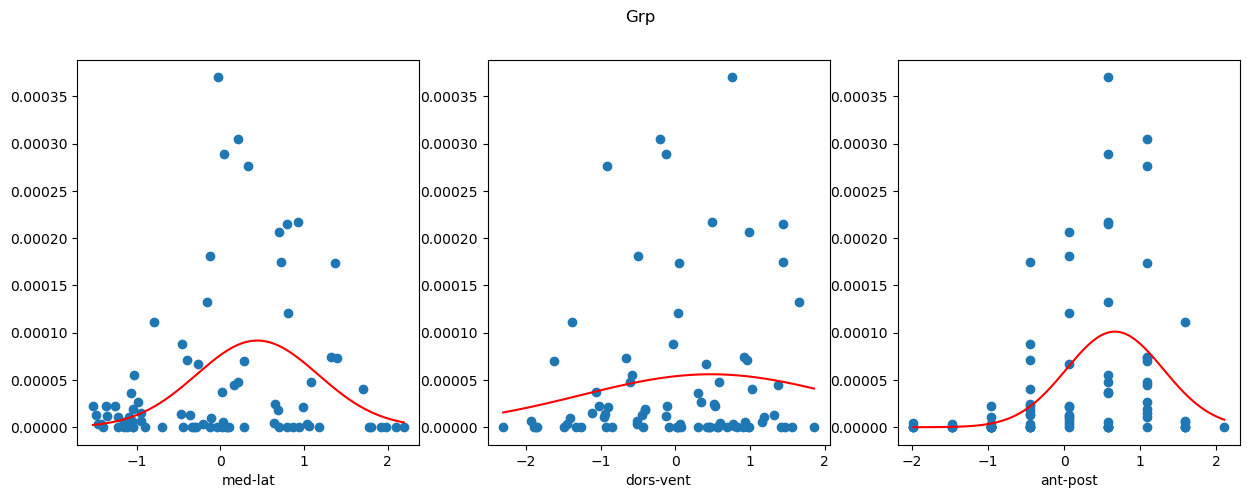

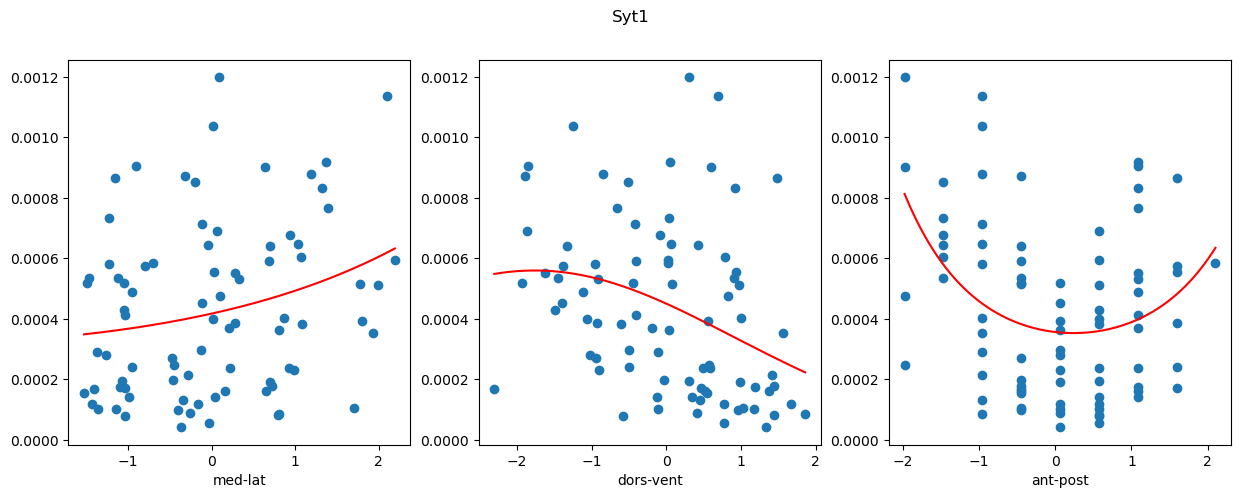

In [33]:
# now fit all the zonated genes, and plot the output of the fit
# for every gene plot the 3 dimensions side by side

for i, g in enumerate(zonated_genes):
    plt.figure(figsize=(15,5))
    plt.suptitle(g)
    for d in range(3):
        theta[i, :] , _ = curve_fit(func_2, coord[:,d], adata[:,g].layers['norm'].squeeze(), p0=(0, 0, 0))
        plt.subplot(1,3,d+1)
        plt.scatter(coord[:,d] , adata[:,g].layers['norm'], label = 'data')
        plt.plot(space[:,d], func_2(space[:,d], *theta[i,:]), c = 'r', label = 'fit')
        plt.xlabel(space_labels[d])
 
    plt.show()
    

In [34]:
theta

array([[ -2.49416066,   1.76790127,  -5.63876991],
       [ -0.05899082,  -0.10216692,  -7.99305189],
       [ -0.55749003,   0.8855271 ,  -8.3328925 ],
       [  0.27248301,   0.4461523 ,  -9.16333237],
       [ -0.280542  ,  -0.23475853,  -7.8120617 ],
       [ -0.08134642,   0.65353801, -10.97339923],
       [ -0.52139907,  -0.1481161 ,  -7.457657  ],
       [ -0.674466  ,  -1.00823823,  -9.34262758],
       [ -1.22968294,   1.63767592,  -9.74476182],
       [  0.16935362,  -0.08167512,  -7.93996813]])